In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import norm
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import QuantileRegressor
import matplotlib.pyplot as plt

seed = 0

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Sample Quantile Regression

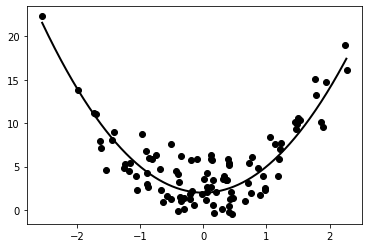

In [2]:
## Nonlinear relationship
# Generate random data
N = 100
x = np.random.normal(loc=0,scale=1,size=N)
epsilon = np.random.normal(loc=0,scale=2,size=N)
B0 = 2
B2 = 3
y = B0 + B2*x**2 + epsilon

x_test = np.arange(start=min(x),stop=max(x),step=0.01)
y_true = B0 + B2*x_test**2

plt.scatter(x,y,color='k')
plt.plot(x_test,y_true,color='k',linewidth=2)

(-0.27281268967384475, array([-0.08657815,  2.80852425]))


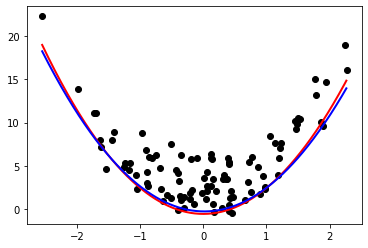

In [3]:
# Consider the 10% quantile
# Test/plot fits
plt.scatter(x,y,color='k')
plt.plot(x_test,y_true+norm.ppf(0.1,scale=2),color='r',linewidth=2)

# Run a quadratic quantile regression (since we know this is the ground truth)
quad_reg = QuantileRegressor(quantile=0.1, alpha=0) #alpha is for a Lasso-type penalty term
X = np.transpose(np.vstack((x,x**2)))
quad_reg.fit(X, y)
print((quad_reg.intercept_ , quad_reg.coef_))

X_test = np.transpose(np.vstack((x_test,x_test**2)))
y_quad_pred = quad_reg.predict(X_test)
plt.plot(x_test,y_quad_pred,color='b',linewidth=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


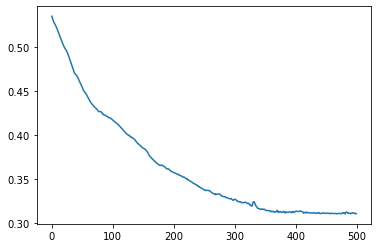

In [4]:
nn_reg = keras.Sequential()
nn_reg.add(keras.layers.Dense(16, input_dim=1,activation='relu')) #1 input x
nn_reg.add(keras.layers.Dense(16, activation='relu'))
nn_reg.add(keras.layers.Dense(1, activation='linear')) #1 output y

nn_reg.summary()

# We need to create our own loss function
import keras.backend as K
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss
    
    return ql

# State the loss function and optimizer (adam is a good choice usually)
nn_reg.compile(optimizer=keras.optimizers.Adam(),loss=quantile_loss(0.1)) #Now we minimize our custom loss function

# Fit the model to training data
losses = nn_reg.fit(x,y,epochs=500,verbose=0) # Fit the model to training data
# View improvement over epochs
plt.plot(losses.history['loss'])
plt.show()

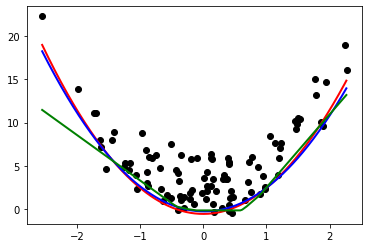

In [5]:
# Predict with the neural network
y_nn_pred = nn_reg.predict(x_test)
plt.scatter(x,y,color='k')
plt.plot(x_test,y_true+norm.ppf(0.1,scale=2),color='r',linewidth=2)
plt.plot(x_test,y_quad_pred,color='b',linewidth=2)
plt.plot(x_test,y_nn_pred,color='g',linewidth=2)

# Value-at-Risk

In [6]:
# Download financial data:
import yfinance
from datetime import datetime

myData = yfinance.download(["AAPL","AMZN","GS","GE","F"],datetime(2019,1,1),datetime(2022,12,31))
AAPL = myData["Adj Close"]["AAPL"]
AMZN = myData["Adj Close"]["AMZN"]
GS = myData["Adj Close"]["GS"]
GE = myData["Adj Close"]["GE"]
F = myData["Adj Close"]["F"]


# Daily log returns
rAAPL = np.log(AAPL) - np.log(AAPL.shift(1))
rAAPL = rAAPL.to_numpy()
rAAPL = np.delete(rAAPL , 0) # Remove first date because 1 lag in returns

rAMZN = np.log(AMZN) - np.log(AMZN.shift(1))
rAMZN = rAMZN.to_numpy()
rAMZN = np.delete(rAMZN , 0) # Remove first date because 1 lag in returns

rGS = np.log(GS) - np.log(GS.shift(1))
rGS = rGS.to_numpy()
rGS = np.delete(rGS , 0) # Remove first date because 1 lag in returns

rGE = np.log(GE) - np.log(GE.shift(1))
rGE = rGE.to_numpy()
rGE = np.delete(rGE , 0) # Remove first date because 1 lag in returns

rF = np.log(F) - np.log(F.shift(1))
rF = rF.to_numpy()
rF = np.delete(rF , 0) # Remove first date because 1 lag in returns

Returns = np.vstack((rAAPL,rAMZN,rGS,rGE,rF)).T
print(Returns.shape)

assets = Returns.shape[1]
N = Returns.shape[0]

[*********************100%***********************]  5 of 5 completed
(1007, 5)


0.08764940239043825

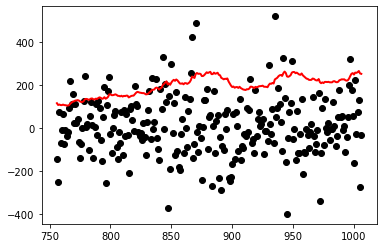

In [7]:
## Compute 95%-VaR for equal weighted portfolio ($100 in each asset)
# Historical perspective
T = 252*3 # Consider rolling window of approximately 3 years of daily data

V = assets*100
VaR_hist = np.zeros(N-T)
true_val = np.zeros(N-T)
for t in range(T,N):
    price = [AAPL[t+1],AMZN[t+1],GS[t+1],GE[t+1],F[t+1]] # Remember, we never removed a row from the prices
    w = np.divide(100 , price)
    
    port_ret = Returns[range(t-T,t),:] @ w # Returns of that portfolio over our rolling window
    port_val = V*port_ret
    VaR_hist[t-T] = -np.quantile(port_val , q=0.05)
    
    true_val[t-T] = V*Returns[t,:] @ w

#Let's plot our VaR over time
plt.scatter(range(T,N) , -true_val , color='k')
plt.plot(range(T,N) , VaR_hist , color='r',linewidth=2)

# Empirically we exceed our 95% VaR some of the time:
np.mean(-true_val > VaR_hist)

In [8]:
### SKIP BECAUSE TAKES TOO LONG
#
### Compute 95%-VaR for equal weighted portfolio ($100 in each asset)
## Linear quantile regression
#T = 252*3 # Consider rolling window of approximately 3 years of daily data
#
#V = assets*100
#VaR_quant = np.zeros(N-T)
#quant_reg = QuantileRegressor(quantile=0.05, alpha=0) #alpha is for a Lasso-type penalty term
#for t in range(T,N):
#    print(t) #Note how slow this method is
#    price = [AAPL[t+1],AMZN[t+1],GS[t+1],GE[t+1],F[t+1]] # Remember, we never removed a row from the prices
#    w = np.divide(100 , price)
#    
#    port_ret = Returns[range(t-T,t),:] @ w # Returns of that portfolio over our rolling window
#    
#    quant_reg.fit(Returns[range(t-T,t-1),:] , port_ret[range(1,T)]) # lag the returns by 1
#    VaR_quant[t-T] = -V*quant_reg.predict(Returns[t-1,:].reshape(1,-1))
#    
##Let's plot our VaR over time
#plt.scatter(range(T,N) , -true_val , color='k')
#plt.plot(range(T,N) , VaR_quant , color='r',linewidth=2)
#
## Empirically we exceed our 95% VaR some of the time:
#np.mean(-true_val > VaR_quant)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


0.16733067729083664

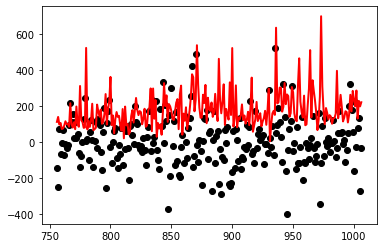

In [9]:
# What if we try a nonlinear fit
V = assets*100
VaR_NN = np.zeros(N-T)

nn_reg = keras.Sequential()
nn_reg.add(keras.layers.Dense(10, input_dim=5,activation='relu')) #5 input x
nn_reg.add(keras.layers.Dense(1, activation='linear')) #1 output y

nn_reg.summary()

# State the loss function and optimizer (adam is a good choice usually)
nn_reg.compile(optimizer=keras.optimizers.Adam(),loss=quantile_loss(0.05)) #Now we minimize our custom loss function

for t in range(T,N):
    price = [AAPL[t+1],AMZN[t+1],GS[t+1],GE[t+1],F[t+1]] # Remember, we never removed a row from the prices
    w = np.divide(100 , price)
    
    port_ret = Returns[range(t-T,t),:] @ w # Returns of that portfolio over our rolling window
    
    nn_reg.fit(Returns[range(t-T,t-1),:] , port_ret[range(1,T)] , epochs=50 , verbose=0) # lag the returns by 1
    VaR_NN[t-T] = -V*nn_reg.predict(Returns[t-1,:].reshape(1,-1))
    
#Let's plot our VaR over time
plt.scatter(range(T,N) , -true_val , color='k')
plt.plot(range(T,N) , VaR_NN , color='r',linewidth=2)

# Empirically we exceed our 95% VaR some of the time:
np.mean(-true_val > VaR_NN)

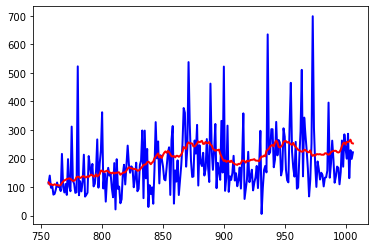

In [10]:
# Let's directly compare our VaR estimates
plt.plot(range(T,N) , VaR_NN , color='b',linewidth=2)
#plt.plot(range(T,N) , VaR_quant , color='b',linewidth=2)
plt.plot(range(T,N) , VaR_hist , color='r',linewidth=2)

In [11]:
# Finally, let's test if either regression is better than the historical approach
def QL(y_true , y_pred , q):
    e = y_true - y_pred
    #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
    loss = np.mean(np.maximum(q*e , (q-1)*e)) 
    return loss

S_hist = np.zeros(N-T)
#S_quant = np.zeros(N-T)
S_NN = np.zeros(N-T)
for i in range(0,N-T):
    S_hist[i] = QL(true_val , -VaR_hist[i] , 0.05)
#    S_quant[i] = QL(true_val , -VaR_quant[i] , 0.05)
    S_NN[i] = QL(true_val , -VaR_NN[i] , 0.05)
    
d = S_NN - S_hist
d_bar = np.mean(d)
d_sig = np.std(d)
print((d_bar , d_sig)) #Investigate the statistics of d

sig = d_sig / np.sqrt(N-T)
print(sig)

# Compute p-value
print(norm.cdf(d_bar/sig))
# This is not statistically significant
# Fail to reject the null hypothesis
# NN is not (statistically significant) better than historical

print(norm.cdf(-d_bar/sig))
# This *is* statistically significant
# Reject the null hypothesis
# Historical perspective is statistically significant better than historical

(4.003841209619463, 6.048630437041829)
0.38178616782678215
1.0
4.9494759166980995e-26
